# CS498 Project, Team 31, Phase 2
## Sentiment Analysis of Social Media as a predictor for Bitcoin price volatility

### Use a subset of the data collected (specifically 10/01/2017 to 12/31/2017) and conduct sentiment analysis of comments to plot the results against the historical price fluctuations studied in Phase 1. 

#### Lets extract sentiments from r/Bitcoin subreddit using SentimentIntensityAnalyzer from nltk.sentiment.

In [ ]:
#Adapted from https://github.com/dewarim/reddit-data-tools/blob/master/src/main/python/scoreCommentsJson.py
#Run Command: python scoreCommentsJson.py /data/location/reddit_comments.bz2 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

import bz2
import lzma
import json
import sys
import os.path

sid = SentimentIntensityAnalyzer()
archive = ""
if len(sys.argv) > 1:
    archive = sys.argv[1]
else:    
    print("No command line arguments given - exiting")
    sys.exit()

print("Working on file: " + archive)
score_file_name = archive.replace("bz2", "sentiment")
if os.path.exists(score_file_name):
    print("sentiment file already exists")
    sys.exit()

bz_file = lzma.LZMAFile(archive, 'rb', 1000000)
score_file = open(score_file_name, 'w')

commentCount = 0
while True:
    line = bz_file.readline().decode('utf8')
    if len(line) == 0: break
    comment = json.loads(line)
    id = comment["id"]
    body = comment["body"]
    subreddit_id = comment["subreddit_id"]
    created_utc = comment["created_utc"]
    if subreddit_id == 't5_2s3qj': #If subreddit is Bitcoin
        # variables to hold the overall average compound score for message
        finalScore = 0
        roundedFinalScore = 0
        # variables to hold the highest positive score in the message
        # and highest negative score in the message
        maxPosScore = 0
        maxNegScore = 0
        commentLines = tokenize.sent_tokenize(body)
        for line in commentLines:
            ss = sid.polarity_scores(line)
            lineCompoundScore = ss['compound']
            finalScore += lineCompoundScore

            if ss['pos'] > maxPosScore:
                maxPosScore = ss['pos']
            elif ss['neg'] > maxNegScore:
                maxNegScore = ss['neg']

        # roundedFinalScore is the average compound score for the entire message
        commentLength = len(commentLines)
        if commentLength == 0:
            commentLength = 1
        roundedFinalScore = round(finalScore / commentLength, 4)
        score_file.write("{0}\t{1}\t{2}\t{3}\t{4}\n".format(roundedFinalScore, maxPosScore, maxNegScore, id, created_utc))
        commentCount += 1
        if commentCount % 1000 == 0:
            print(commentCount)
bz_file.close()
score_file.close()

#### The sentiments is stored in XXX.sentiment file in format: totalScore, PositiveScore, NegativeScore, Comment_id, created_utc

#### Now lets plot point graph for comments (that aren't zero aka neutral) for the month of ~~Oct Nov~~ Dec 2017

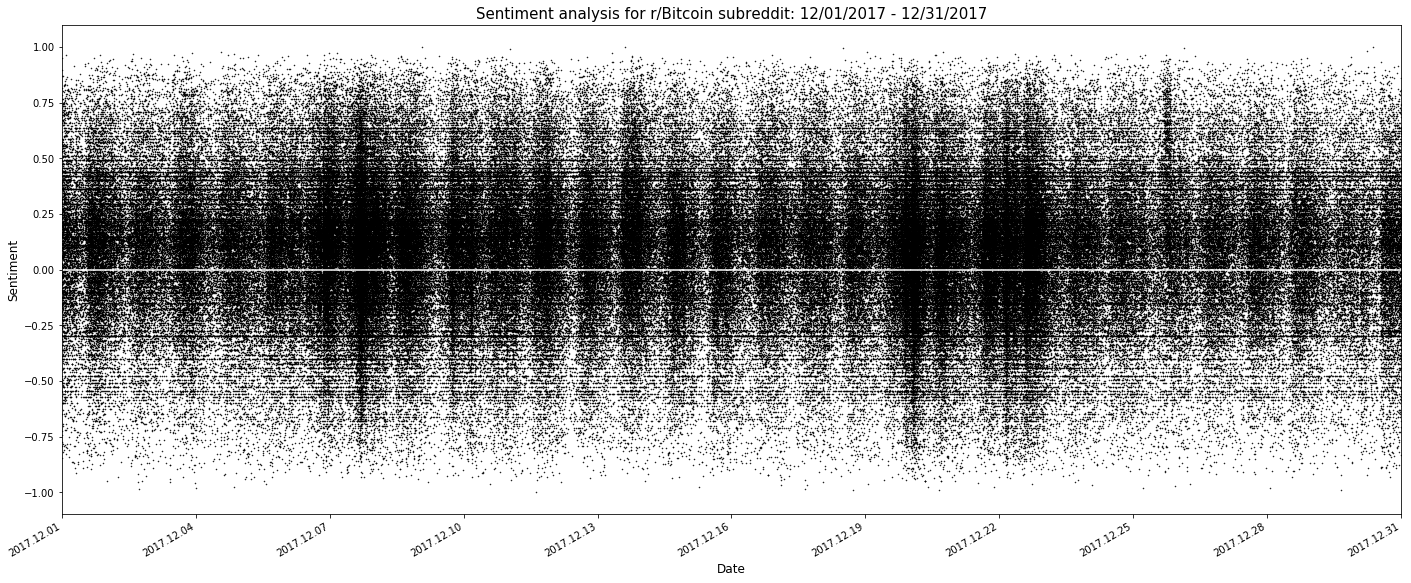

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import numpy as np
import csv
%matplotlib inline
sentiments = []
epoches = []
with open('data/RC_2017-12.sentiment', newline='') as csvfile:
    creader = csv.reader(csvfile, delimiter='\t')
    for row in creader:
        temp = float(row[0])
        if temp!=0.0: #Remove points that have neither positive nor negative sentiments
            sentiments.append(temp)
            epoches.append(int(row[4]))

epoches = [mdates.epoch2num(e) for e in epoches] #Convert to nums
epoches = [mdates.num2date(e) for e in epoches] #Convert to datetimes

fig, ax = plt.subplots(figsize=(24,10))
plt.plot(epoches,sentiments,'.', color='black', ms=1)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
ax.set_xlim([datetime.date(2017, 12, 1), datetime.date(2017, 12, 31)])
#ax.legend()
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sentiment', fontsize=12)
plt.title("Sentiment analysis for r/Bitcoin subreddit: 12/01/2017 - 12/31/2017", fontsize=15)
plt.axhline(0, color='white')
plt.show()

#### Lets see how +ve or -ve the sentiments are using a histogram

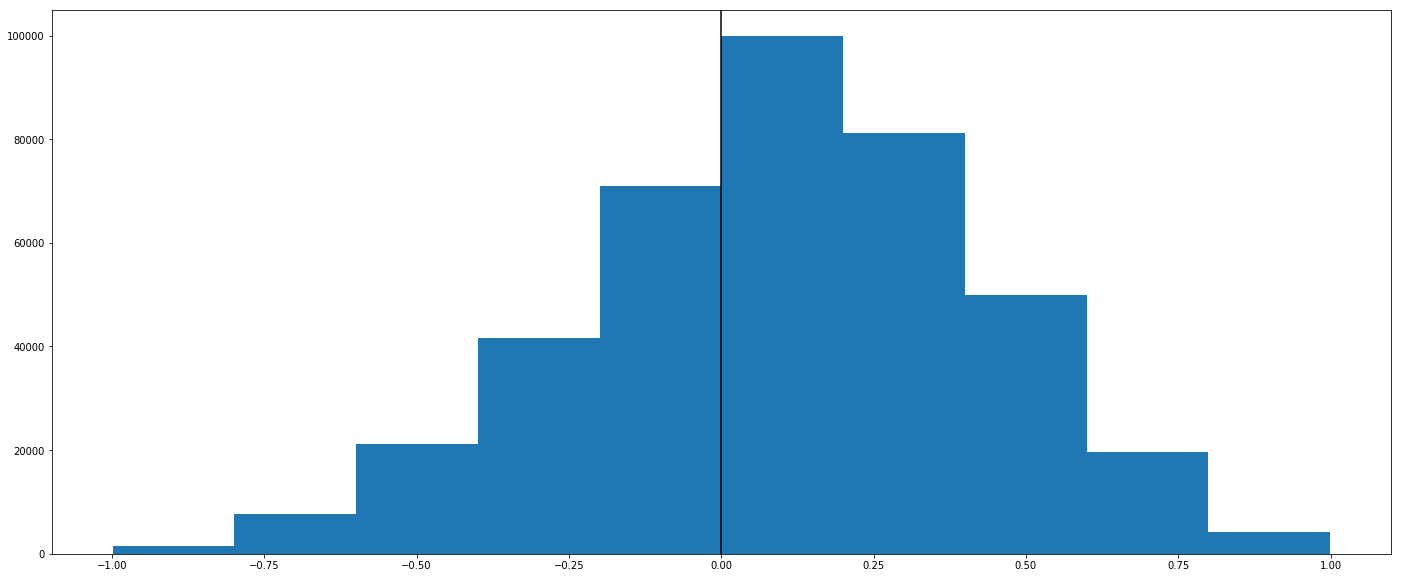

In [10]:
fig, ax = plt.subplots(figsize=(24,10))
plt.hist(sentiments)
plt.axvline(0, color='black')
plt.show()

#### We see they are mostly neutral to positive. Now lets see how many are +ve vs -ve on a daily basis using a 2D histogram

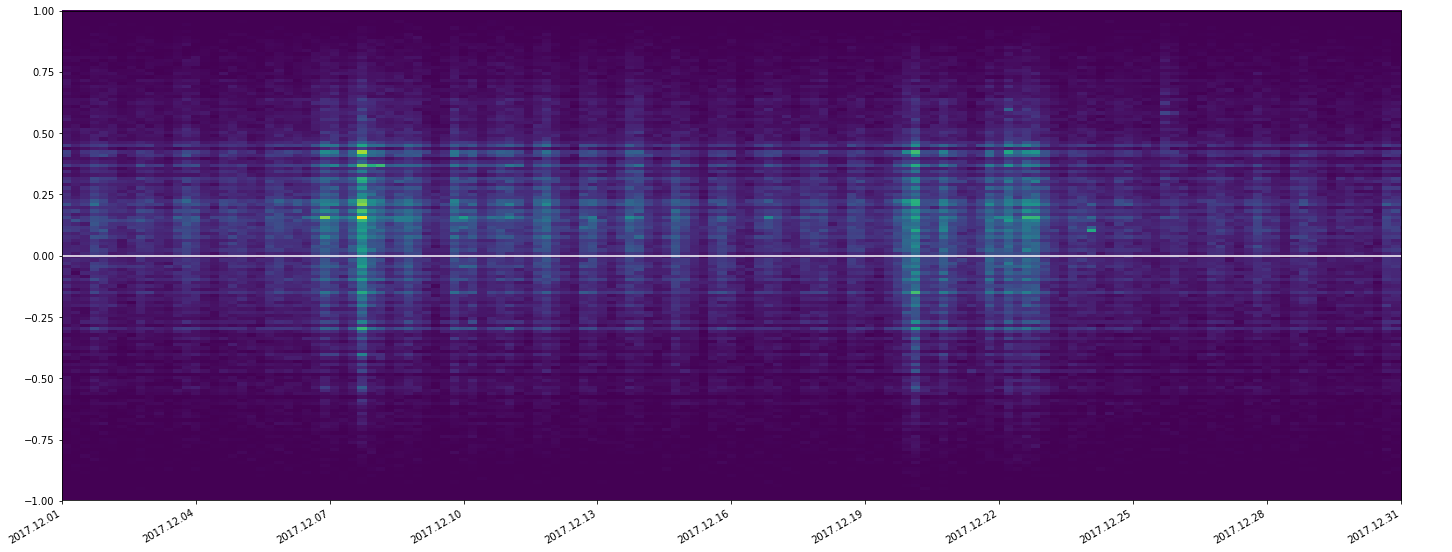

In [11]:
fig, ax = plt.subplots(figsize=(24,10))
epoches = [mdates.date2num(e) for e in epoches]
hist = ax.hist2d(epoches,sentiments,bins=150)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
ax.set_xlim([datetime.date(2017, 12, 1), datetime.date(2017, 12, 31)])
plt.axhline(0, color='white')
fig.autofmt_xdate()
plt.show()

#### Colorful! Lets look at averages and medians of the sentiments for each day from Oct to Nov 2017 and then plot a bar graph

In [15]:
import pytz #For timezone
from statistics import mean, median
tomorrow = datetime.datetime(2017,10,2,tzinfo=pytz.UTC)
temp = []
means = []
medians = []
with open('data/RC_2017-10.sentiment', newline='') as csvfile:
    creader = csv.reader(csvfile, delimiter='\t')
    for row in creader:
        current = mdates.epoch2num(int(row[4])) #Convert to nums
        current = mdates.num2date(current) #Convert to datetimes
        if tomorrow > current:
            if row[0]!='0.0':
                temp.append(float(row[0]))
        else:
            tomorrow = tomorrow + datetime.timedelta(days=1)
            means.append(mean(temp))
            medians.append(median(temp))
            temp=[]

with open('data/RC_2017-11.sentiment', newline='') as csvfile:
    creader = csv.reader(csvfile, delimiter='\t')
    for row in creader:
        current = mdates.epoch2num(int(row[4])) #Convert to nums
        current = mdates.num2date(current) #Convert to datetimes
        if tomorrow > current:
            if row[0]!='0.0':
                temp.append(float(row[0]))
        else:
            tomorrow = tomorrow + datetime.timedelta(days=1)
            means.append(mean(temp))
            medians.append(median(temp))
            temp=[]
            
with open('data/RC_2017-12.sentiment', newline='') as csvfile:
    creader = csv.reader(csvfile, delimiter='\t')
    for row in creader:
        current = mdates.epoch2num(int(row[4])) #Convert to nums
        current = mdates.num2date(current) #Convert to datetimes
        if tomorrow > current:
            if row[0]!='0.0':
                temp.append(float(row[0]))
        else:
            tomorrow = tomorrow + datetime.timedelta(days=1)
            means.append(mean(temp))
            medians.append(median(temp))
            temp=[]

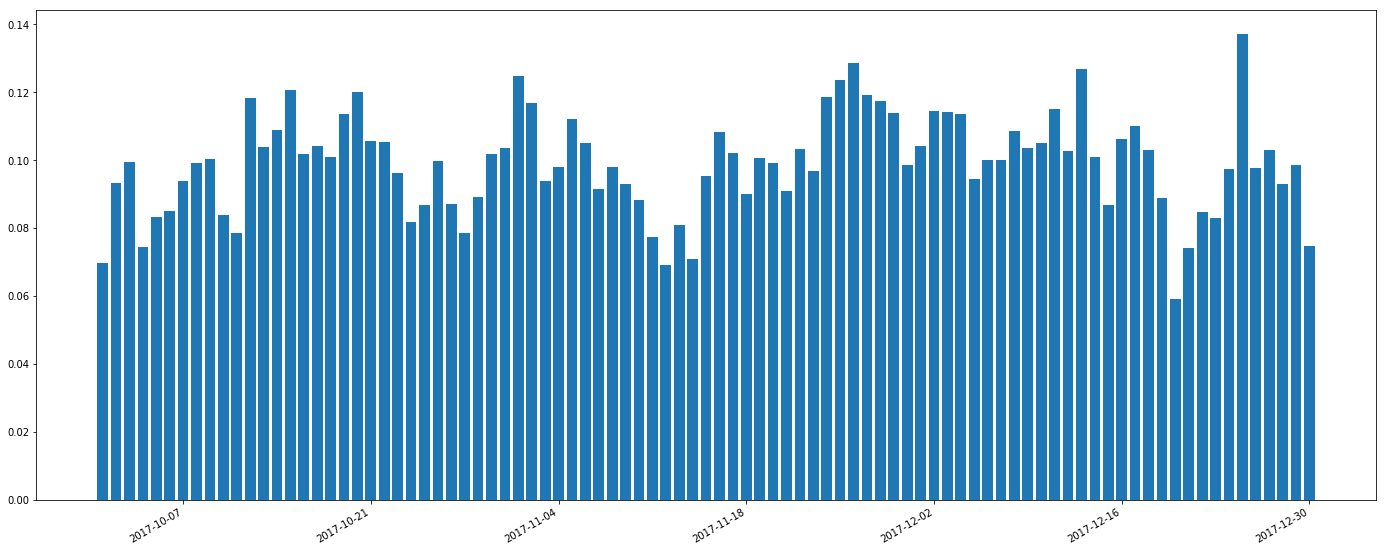

In [25]:
#means
d1 = datetime.datetime(2017,10,1)
d2 = datetime.datetime(2017,12,31)
x = [d1+datetime.timedelta(days=x) for x in range((d2-d1).days)]
y = means
fig, ax = plt.subplots(figsize=(24,10))
ax.bar(x, y)
#print(x[:10])
ax.xaxis_date()
fig.autofmt_xdate()
#plt.xticks(x)
#plt.xticks(rotation=30)
plt.show()

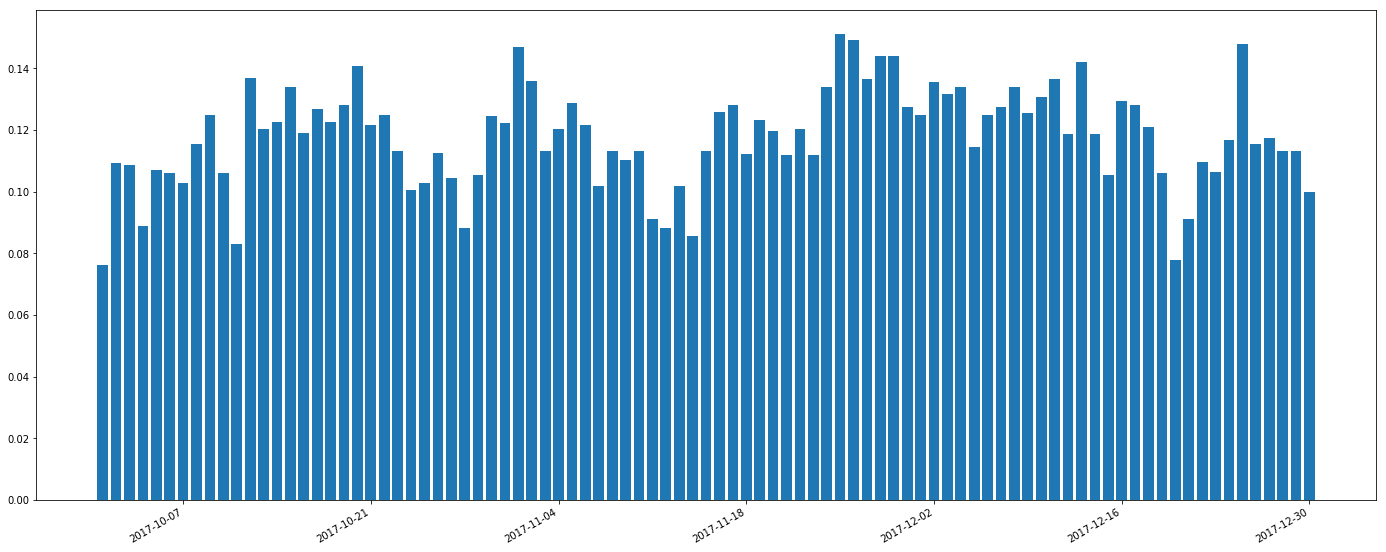

In [26]:
#medians
y = medians
fig, ax = plt.subplots(figsize=(24,10))
ax.bar(x, y)
ax.xaxis_date()
fig.autofmt_xdate()
plt.show()